## Секция импортов

In [4]:
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import wave
import cv2

import IPython

## Классы

In [5]:
class BaseModality(ABC):
    
    """Template for each modality preprocessing"""
    
    path: str
    
    def __init__(self, path):
        self.path = path
        self.opened = None
    
    @abstractmethod
    def load_from_file(self):
        pass
    
    @abstractmethod
    def display(self):
        pass

In [78]:
class AudioModality(BaseModality):
    
    """Redefine methods from base class for audio tracks."""
    
    def __init__(self, path):
        super().__init__(path)
        self.samples = 0
        self.rate = 0
        self.channels = 0
    
    def load_from_file(self):
        """Load wav file"""
        if self.path[-4:] == '.wav':
            self.opened = wave.open(self.path)
            self.samples = self.opened.getnframes()
            self.rate = self.opened.getframerate()
            self.channels = self.opened.getnchannels()
        
    def __to_numpy_array(self):
        """Convert wav to numpy array:
        1. get float-32 array,
        2. normalise it
        Retrieved from https://stackoverflow.com/questions/16778878/python-write-a-wav-file-into-numpy-float-array"""
        if self.opened:
            audio = self.opened.readframes(self.samples)

            audio_as_np_int16 = np.frombuffer(audio, dtype=np.int16)
            audio_as_np_float32 = audio_as_np_int16.astype(np.float32)  

            max_int16 = 2**15
            audio_normalised = audio_as_np_float32 / max_int16

            return audio_normalised
    
    def __to_mono(self, audio_normalised):
        """Extract first channel from stereo sound:
        1. create 2-d numpy array,
        2. return its first dimension
        Also retrieved from https://stackoverflow.com/questions/16778878/python-write-a-wav-file-into-numpy-float-array"""
        if isinstance(audio_normalised, np.ndarray):
            audio_stereo = np.empty((int(len(audio_normalised)/self.channels), self.channels))
            audio_stereo[:,0] = audio_normalised[range(0,len(audio_normalised),2)]
            audio_stereo[:,1] = audio_normalised[range(1,len(audio_normalised),2)]

            return audio_stereo[:,0]
        
    def __get_index(self, time: float):
        if isinstance(time, float) and time > 0:
            return int(time*self.rate)
        
    def display(self, start=0, end=0):
        """Display audio tracks with given start and end points
        
        Parameters
        ----------
        start : float; default `0`
        end : float; default `0`
        
        Call `load_from_file` before calling this function"""
        if self.opened:
            self.opened = wave.open(self.path)

            start_ind = self.__get_index(float(start))
            end_ind = self.__get_index(float(end))

            audio_norm = self.__to_numpy_array()
            mono_audio_norm = self.__to_mono(audio_norm)

            if not start_ind:
                start_ind = 0
            if not end_ind:
                end_ind = len(mono_audio_norm)

            if start_ind > end_ind or start_ind > len(mono_audio_norm):
                return "The audio cannot be displayed"
            else:
                return IPython.display.Audio(mono_audio_norm[start_ind: end_ind], rate=self.rate)
        
    def get_waveform(self):
        """Draw audio in a wave form"""
        self.opened = wave.open(self.path)
        
        audio_norm = self.__to_numpy_array()
        mono_audio_norm = self.__to_mono(audio_norm)
        
        plt.plot(np.array(range(0, self.samples)), mono_audio_norm)
        
    def __repr__(self):
        return f"Audio available at {self.path}\nSamples: {self.samples}\nFrame rate: {self.rate}\nChannels: {self.channels}"

In [7]:
class VideoModality(BaseModality):
    
    """Redefine methods from base class for video streams."""
    
    def __init__(self, path):
        super().__init__(path)
        self.n_frames = 0
    
    def load_from_file(self):
        """Load video file (available formats: mp4, avi)"""
        self.opened = cv2.VideoCapture(self.path)
    
    def display(self):
        """Display video file"""
        return IPython.display.Video(self.path, embed=True, width=360)
    
    def track_face(self):
        """Create simple face tracking array: [[time in sec, 1 if there is a face], ...]"""
        face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        
        n_frame = 0
        face_tracking_ar = np.array([[0, 0]])
        
        while True:
            ret, frame = self.opened.read()
            if not isinstance(frame, np.ndarray):
                break
            n_frame += 1
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, 1.3, 5)
            for (x,y,w,h) in faces:
                face_tracking_ar = np.append(face_tracking_ar, [[n_frame/30, 1]], axis=0)
                break
            else:
                face_tracking_ar = np.append(face_tracking_ar, [[n_frame/30, 0]], axis=0)
        
        self.n_frames = n_frame
        self.opened.release()
        return face_tracking_ar
    
    def __repr__(self):
        return f'Video available at {self.path}\nFrame number: {self.n_frames}'

In [130]:
class TextModality(BaseModality):
    
    """Redefine methods from base class for extracted text.
    Class works with .txt files loaded from Praat."""
    
    path : str
    tier_name : str
    
    def __init__(self, path, tier_name):
        super().__init__(path)
        self.tier_name = tier_name
    
    def load_from_file(self):
        """Load txt file with manual annotations"""
        if self.path[-4:] == '.txt':
            self.opened = pd.read_csv(self.path, sep='\t')
            if 'tier' in self.opened.columns:
                self.opened.drop(self.opened[self.opened['tier'] != self.tier_name].index, inplace=True)
            else:
                self.opened = None
    
    def __make_html_table(self):
        paragraphs = ['<table><tbody>']
        
        for i in range(self.opened.shape[0]):
            paragraphs.append('<tr>')
            paragraphs.append(f'<td>{self.opened.tmin.iloc[i]}</td>')
            paragraphs.append(f'<td>{self.opened.tmax.iloc[i]}</td>')
            paragraphs.append(f'<td width="500" style="text-align: left;">{self.opened.text.iloc[i]}</td>')
            paragraphs.append('</tr>')
            
        paragraphs.append('</tbody></table></span>')
        
        return ''.join(paragraphs)
        
    
    def display(self):
        """Display text segments as a table"""
        return IPython.display.HTML(self.__make_html_table())
    
    def __repr__(self):
        return f"Text data available at {self.path}\nUtterance number: {self.opened.shape[0]}"

**Тестируем аудиальную модальность**

In [83]:
aud = AudioModality('C:\\Диплом Аня\\Speakers audio wav\\RU_FR_5.wav')
aud.load_from_file()

In [85]:
aud.display(1, 5)

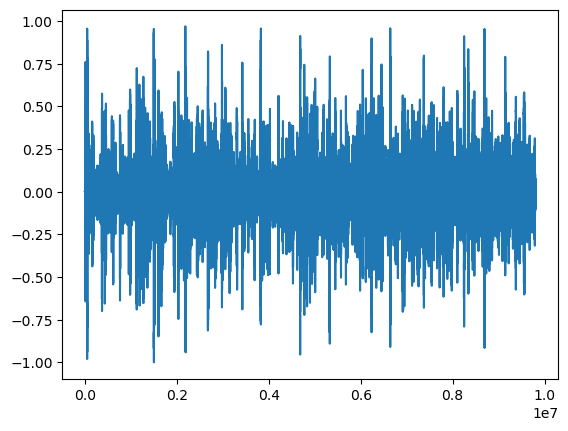

In [11]:
aud.get_waveform()

In [12]:
print(aud)

Audio available at C:\Диплом Аня\Speakers audio wav\RU_FR_5.wav
Samples: 9809327
Frame rate: 44100
Channels: 2


**Тестируем текстовую модальность**

In [13]:
text = TextModality('C:\\Диплом Аня\\Speakers audio wav\\RU_FR_1.txt', 'P-EDUs')

In [14]:
text.load_from_file()

In [15]:
text.display()

1.133548,1.955787,Оделась.
2.244416,3.494792,"(0.28) Сделала кста-ати,"
3.669461,4.421836,(0.17)два рукава=
4.422327,7.183845,(скл.) точнее (0.09) резинки на рукава для кардигана который я вяжу.
7.183845,8.844326,"(скл.) Я сегодня иду на день рождения,"
8.844326,9.964376,к (э 0.22) Вове утром.
10.152596,11.738351,(0.18) Я думаю что некоторые его знаю=.
11.738351,14.620567,(скл.) У меня /\странное ощущение по этому /поводу потому-у что=
14.620567,17.991615,(скл.) Я настолько (э 0.17) давно-о не-е (0.63) была в социуме.
17.991615,18.984172,"(скл.) В том плане что,"
19.316152,23.372747,(0.33) я очень-очень-очень давно социализировалась прямо нормально с /людьми.


In [16]:
print(text)

Text data available at C:\Диплом Аня\Speakers audio wav\RU_FR_1.txt
Utterance number: 86


**Тестируем визуальную модальность**

In [17]:
vid = VideoModality('C:\\Диплом Аня\\Speakers video mp4\\RU_FR_3_Trim.mp4')

In [18]:
vid.load_from_file()

In [19]:
result = vid.track_face()

In [20]:
result.shape[0] - result[:,1].sum()

119.0

In [21]:
print(vid)

Video available at C:\Диплом Аня\Speakers video mp4\RU_FR_3_Trim.mp4
Frame number: 158


In [22]:
vid.display()

## Юнит-тесты

In [39]:
import unittest

In [100]:
class TestAudioLoad(unittest.TestCase):
    def test_good_audio_file(self):
        path = 'C:\\Диплом Аня\\Speakers audio wav\\RU_FR_5.wav'
        aud = AudioModality(path)
        aud.load_from_file()
        self.assertTrue(aud.samples != 0)
        self.assertTrue(aud.rate != 0)
        self.assertTrue(aud.channels != 0)
        
    def test_anothertype_audio_file(self):
        path = 'C:\\01_АНЯ\\Музыка\\О зайце.mp3'
        aud = AudioModality(path)
        aud.load_from_file()
        self.assertFalse(aud.samples != 0)
        self.assertFalse(aud.rate != 0)
        self.assertFalse(aud.channels != 0)
    
    def test_nonaudiotype_file(self):
        path = 'C:\\Диплом Аня\\Speakers video mp4\\RU_FR_3_Trim.mp4'
        aud = AudioModality(path)
        aud.load_from_file()
        self.assertFalse(aud.samples != 0)
        self.assertFalse(aud.rate != 0)
        self.assertFalse(aud.channels != 0)

In [101]:
class TestAudioDisplay(unittest.TestCase):
    def setUp(self):
        self.wav_format = AudioModality('C:\\Диплом Аня\\Speakers audio wav\\RU_FR_5.wav')
        self.mp3_format = AudioModality('C:\\01_АНЯ\\Музыка\\О зайце.mp3')
        self.nonaudio_format = AudioModality('C:\\Диплом Аня\\Speakers video mp4\\RU_FR_3_Trim.mp4')

    @classmethod
    def setUpClass(cls):
        pass
    
    def tearDown(self):
        pass
        
    def test_good_audio_input_classic(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display(1.1, 5.2)
        self.assertTrue(isinstance(objet, IPython.lib.display.Audio))
        
    def test_good_audio_input_only_start(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display(197)
        self.assertTrue(isinstance(objet, IPython.lib.display.Audio))
        
    def test_good_audio_input_only_end(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display(end=15)
        self.assertTrue(isinstance(objet, IPython.lib.display.Audio))
        
    def test_good_audio_input_no_end_no_start(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display()
        self.assertTrue(isinstance(objet, IPython.lib.display.Audio))
        
    def test_good_audio_input_start_gt_end(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display(65, 5)
        self.assertTrue(objet == "The audio cannot be displayed")
        
    def test_good_audio_input_start_too_big(self):
        self.wav_format.load_from_file()
        objet = self.wav_format.display(430)
        self.assertTrue(objet == "The audio cannot be displayed")
        
    def test_anothertype_audio_file(self):
        self.mp3_format.load_from_file()
        objet = self.mp3_format.display()
        self.assertTrue(objet == None)
        
    def test_nonaudiotype_file(self):
        self.nonaudio_format.load_from_file()
        objet = self.nonaudio_format.display()
        self.assertTrue(objet == None)

In [128]:
class TestTextLoad(unittest.TestCase):
    def test_good_text_file(self):
        path = 'C:\\Диплом Аня\\Speakers audio wav\\RU_FR_1.txt'
        tier = 'P-EDUs'
        txt = TextModality(path, tier)
        txt.load_from_file()
        self.assertTrue(isinstance(txt.opened, pd.DataFrame))
        self.assertTrue(txt.opened.tier.shape[0] == txt.opened.shape[0])
        
    def test_good_text_file_no_tier(self):
        path = 'C:\\Диплом Аня\\Speakers audio wav\\RU_FR_1.txt'
        tier = ''
        txt = TextModality(path, tier)
        txt.load_from_file()
        self.assertTrue(isinstance(txt.opened, pd.DataFrame))
        self.assertTrue(txt.opened.shape[0] == 0)
        
    def test_non_text_file(self):
        path = 'C:\\Диплом Аня\\Speakers audio wav\\RU_FR_1.wav'
        tier = 'smth'
        txt = TextModality(path, tier)
        txt.load_from_file()
        self.assertTrue(txt.opened is None)
        
    def test_non_praat_text_file(self):
        path = "C:\\Users\\PC Natalya\\My Jupyter notebooks\\test.txt"
        tier = 'smth'
        txt = TextModality(path, tier)
        txt.load_from_file()
        self.assertTrue(txt.opened is None)

In [131]:
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False, verbosity=2)

test_anothertype_audio_file (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_classic (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_no_end_no_start (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_only_end (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_only_start (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_start_gt_end (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_good_audio_input_start_too_big (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_nonaudiotype_file (__main__.TestAudioDisplay) ... skipped 'demonstrating skipping'
test_anothertype_audio_file (__main__.TestAudioLoad) ... skipped 'demonstrating skipping'
test_good_audio_file (__main__.TestAudioLoad) ... skipped 'demonstrating skipping'
test_nonaudiotype_file (__main__.TestAudioLoad) ... s